In [1]:
import collections
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt

import importlib
import numpy as np
import scipy.stats
import SimpleITK as sitk
import os
from scipy.spatial.distance import euclidean
import imgscroll

## Image Display Functions

Classes and functions to be used later in displaying images are collected here.

In [2]:
def show_imgs(imgstack, imgstack2=None):
    """Uses imgscroll to show stack of images in a new window with 
    mouse scrolling. If a 2nd image stack is provided, then it will 
    be overlaid on top of the 1st. %matplotlib qt must used!"""
    X = sitk.GetArrayFromImage(imgstack)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if imgstack2 is not None:
        X2 = sitk.GetArrayFromImage(imgstack2)
        maskVal = scipy.stats.mode(X2.flatten())[0][0]
        Xmask = np.ma.masked_where(X2 == maskVal, X2)
        tracker = imgscroll.IndexTracker2(ax, X, Xmask)
    else:
        tracker = imgscroll.IndexTracker(ax, X)
    fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
    plt.show()

In [3]:
def input_level_set_click(featImg, slice2coords):
    """Create input level set from coordinates gathered from user mouse clicks.
    A circle of size RADIUS is drawn around each coordinate."""
    RADIUS = 10
    numCols = featImg.GetSize()[0]
    numRows = featImg.GetSize()[1]
    depthSize = featImg.GetSize()[2]
    X = np.zeros((depthSize, numRows, numCols), dtype=np.int)
    
    # draw circle by setting points within radius of coordinate equal to 1
    for n in slice2coords:        
        for c in slice2coords[n]:
            rowIni, rowEnd = c[1] - RADIUS, c[1] + RADIUS
            colIni, colEnd = c[0] - RADIUS, c[0] + RADIUS
            for i in range(rowIni, rowEnd+1):
                for j in range(colIni, colEnd+1):
                    if euclidean((i,j), (c[1], c[0])) <= RADIUS:
                        X[n,i,j] = 1
    
    dilation = sitk.BinaryDilate(sitk.GetImageFromArray(X), 3)
    img = sitk.Cast(dilation, featImg.GetPixelIDValue()) * -1 + 0.5
    img.CopyInformation(featImg)
    
    return img

In [4]:
class IndexMouseCapture(object):
    """For a stack of images, capture and save coordinates from mouse clicks.
    A circle of size RADIUS will be displayed upon each click."""
    
    def __init__(self, ax, X):
        self.ax = ax
        self.X = X
        self.slices, numrows, numcols = X.shape
        self.ind = 0
        self.ind2coord = collections.defaultdict(list)
        self.circles = list()
        
        self.im = ax.imshow(self.X[self.ind, :, :], cmap=plt.cm.Greys_r)
        self.update()

    def onscroll(self, event):
        if event.button == 'up':
            self.ind = np.clip(self.ind+1, 0, self.slices-1)
        else:
            self.ind = np.clip(self.ind-1, 0, self.slices-1)
        for circ in self.circles:
            circ.remove()
        self.circles = list()
        self.update()

    def onclick(self, event):
        RADIUS = 10
        ix, iy = int(round(event.xdata)), int(round(event.ydata))
        self.ind2coord[self.ind].append((ix, iy))
        circ = plt.Circle((ix, iy), RADIUS, color='b')
        plt.gcf().gca().add_artist(circ)
        self.circles.append(circ)
        self.im.axes.figure.canvas.draw()

    def update(self):
        self.im.set_data(self.X[self.ind, :, :])
        self.ax.set_title('slice %s' %self.ind)
        self.im.axes.figure.canvas.draw()

In [5]:
def tile_slices(imgstack, slicesToShow, imgstack2=None):
    """Show a number of slices tiled side-by-side"""
    fig = plt.figure(figsize=(15,10))
    numSlices = len(slicesToShow)
    for i,sliceNum in enumerate(slicesToShow):
        plt.subplot(1, numSlices, i+1)
        plt.imshow(sitk.GetArrayFromImage(imgstack[:,:,sliceNum]), cmap=plt.cm.Greys_r)
        if imgstack2 is not None:
            X2 = sitk.GetArrayFromImage(imgstack2[:,:,sliceNum])
            maskVal = scipy.stats.mode(X2.flatten())[0][0]
            Xmask = np.ma.masked_where(X2 == maskVal, X2)
            plt.imshow(Xmask, alpha=0.5)
        plt.gca().get_xaxis().set_ticks([])
        plt.gca().get_yaxis().set_ticks([])
    fig.subplots_adjust(hspace=0.0, wspace=0.0)
    plt.show()

## Read in DICOM images

The case being analyzed here is a resectable hepatocellular carcinoma from [The Cancer Imaging Archive](http://www.cancerimagingarchive.net). The patient ID is TCGA-BC-4073. Ultimately, the liver along with the tumor and blood vessels are to be reconstructed. Here, the focus is only on the liver. 

In [6]:
import helper_fxns as hf

In [9]:
#imgSeries,_ = hf.dcm_load('./dcm1')

dicomPath = './dcm1'
reader = sitk.ImageSeriesReader()
seriesIDread = reader.GetGDCMSeriesIDs(dicomPath)[0]
reader.SetFileNames(reader.GetGDCMSeriesFileNames(dicomPath, seriesIDread))
imgSeries = reader.Execute()

In [10]:
# choose a series of slices
imgSlices = imgSeries[:,:,60:70]

In [14]:
%gui qt
#%matplotlib osx
# displays scrollable image series in a new window
show_imgs(imgSlices)

Show a few slices, for example, 30, 35, and 39:

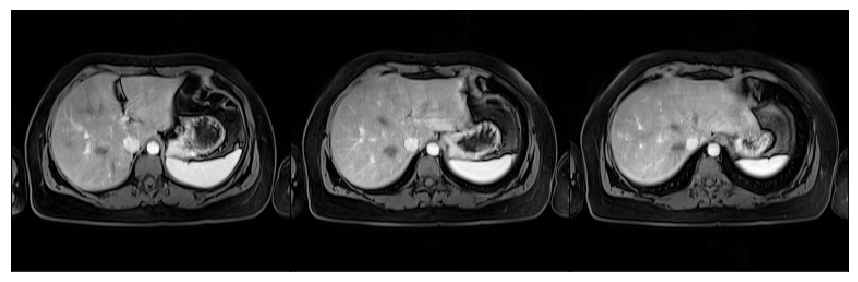

In [41]:
tile_slices(imgSlices, [0, 5, 9])

## Filtering

### Curvature anisotropic diffusion

First, the original image is smoothed with an edge-preserving filter. 

In [15]:
timeStep_, conduct, numIter = (0.04, 9.0, 5)
imgRecast = sitk.Cast(imgSlices, sitk.sitkFloat32)
curvDiff = sitk.CurvatureAnisotropicDiffusionImageFilter()
curvDiff.SetTimeStep(timeStep_)
curvDiff.SetConductanceParameter(conduct)
curvDiff.SetNumberOfIterations(numIter)
imgFilter = curvDiff.Execute(imgRecast)

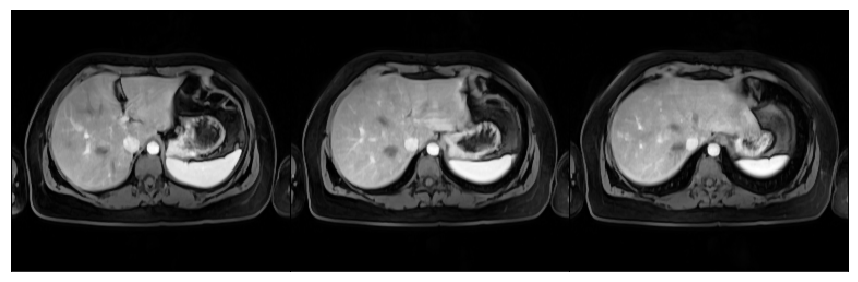

In [48]:
tile_slices(imgFilter, [0, 5, 9])

In [107]:
imgFilter

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x115cfe6c0> >

## Edge potential

### Gradient magnitude recursive Gaussian

In [16]:
sigma_ = 2.0
imgGauss = sitk.GradientMagnitudeRecursiveGaussian(image1=imgFilter, sigma=sigma_)

In [17]:
%gui qt
# %matplotlib qt
# display in new window to find values on boundary
show_imgs(imgGauss)

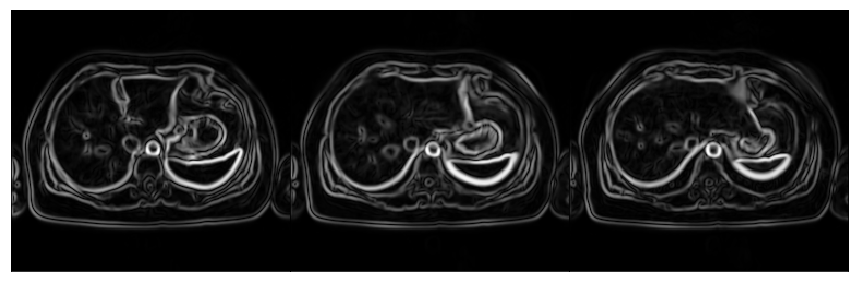

In [49]:
tile_slices(imgGauss, [0, 5, 9])

## Feature Image

### Sigmoid mapping

Following Section 4.3.1 "Fast Marching Segmentation" on pages 373-374 from **The ITK Software Guide Book 2: Design and Functionality, 4<sup>th</sup> ed.** for the setup of the sigmoid filter. The output will be passed along to a segmentation algorithm below. 

Note that the plan is to conduct multiple rounds of segmentation, to "start with a downsampled volume and work back to the full resolution using the results at each intermediate scale as the initialization for the next scale." (pg. 370) Therefore, K1 and K2 below for the sigmoid mapping are first set loosely set and will become more strict in later segmentations. 

In [18]:
K1, K2 = 18.0, 8.0

In [19]:
alpha_ = (K2 - K1)/6
beta_ = (K1 + K2)/2

sigFilt = sitk.SigmoidImageFilter()
sigFilt.SetAlpha(alpha_)
sigFilt.SetBeta(beta_)
sigFilt.SetOutputMaximum(1.0)
sigFilt.SetOutputMinimum(0.0)
imgSigmoid = sigFilt.Execute(imgGauss)

In [20]:
%gui qt
# %matplotlib qt
# examine image series in a new window
show_imgs(imgSigmoid)

Show slices 30, 35, and 39 having computed the gradient and sigmoid mapping:

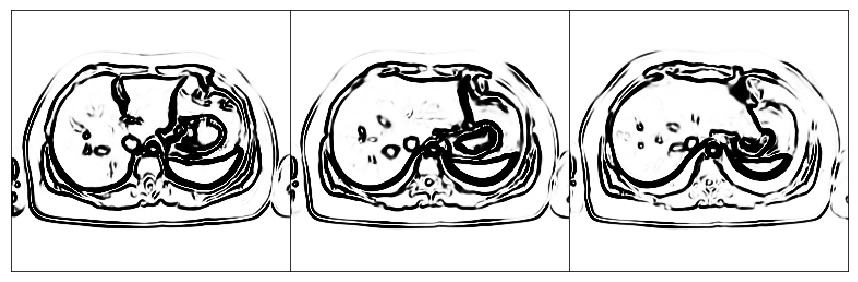

In [46]:
tile_slices(imgSigmoid, [0, 5, 9])

In [35]:
import skimage.segmentation

In [88]:
temp = sitk.GetArrayFromImage(imgFilter[:,:,0])
scaled = (temp - np.amin(temp))/(np.amax(temp) - np.amin(temp))
scaled = (scaled - 0.5)*2

In [96]:
seg = skimage.segmentation.felzenszwalb(scaled, scale=300, sigma=0.1, min_size=2000, multichannel=False)
plt.imshow(seg, cmap=plt.cm.Greys_r)

In [119]:
seg, phi, energies = chan_vese.chan_vese(temp, mu=.5, extended_output=True)
plt.imshow(seg, cmap=plt.cm.Greys_r)

In [108]:
import chan_vese

## Input Level Set

Using ideas from the SimpleITK [geodesic active contour example](http://www.itk.org/SimpleITKDoxygen/html/GeodesicActiceContourSegmentation_8py-example.html) to create an initial input level set. Instead of computing a signed Maurer distance map and then applying a binary threshold, the approach here simply draws a circle of a given radius around each user-chosen seed coordinate. Following the SimpleITK Notebook on [Levelset Segmentation](http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/31_Levelset_Segmentation.html), a binary dilation with a kernel size of 3 is performed. Finally, as was done in the [example](http://www.itk.org/SimpleITKDoxygen/html/GeodesicActiceContourSegmentation_8py-example.html) (line 60), all image values are multiplied by -1 and added to 0.5. The results is the input level set.

Use the class *IndexMouseCapture* (defined above) to capture coordinates from mouse clicks for seeds. The radii are all assumed to be of the same size at the moment. 

In [ ]:
image = imgFilter
seedImage = sitk.Image( image.GetSize()[0], image.GetSize()[1], sitk.sitkUInt8 )
seedImage.SetSpacing( image.GetSpacing() )
seedImage.SetOrigin( image.GetOrigin() )
#seedImage.SetDirection( image.GetDirection() )
seedImage[ seedImage.TransformPhysicalPointToIndex([20,20]) ] = 1

distance = sitk.SignedMaurerDistanceMapImageFilter()
distance.InsideIsPositiveOff()
distance.UseImageSpacingOn()
initImg = sitk.BinaryThreshold( distance.Execute( seedImage ), -1000, 10 )
initImg = sitk.Cast( initImg, imgGauss.GetPixelIDValue() ) * -1 + 0.5

In [21]:
%gui qt
# get coordinates from mouse clicks (opens in new window)
X = sitk.GetArrayFromImage(imgSigmoid)

fig = plt.figure()
ax = fig.add_subplot(111)
tracker = IndexMouseCapture(ax, X)
fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
fig.canvas.mpl_connect('button_press_event', tracker.onclick)

7

In [22]:
# call function to create input level set from the coordinates chosen above by user
initImg = input_level_set_click(imgSigmoid, tracker.ind2coord)

Display slices with the input level set overlaying the sigmoid-mapped image:

In [23]:
tile_slices(imgSigmoid, [4, 5, 6], initImg)

/Users/clintonwang/miniconda3/envs/fast-tf/lib/python3.6/site-packages/matplotlib/colors.py:823: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/Users/clintonwang/miniconda3/envs/fast-tf/lib/python3.6/site-packages/numpy/ma/core.py:2809: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/Users/clintonwang/miniconda3/envs/fast-tf/lib/python3.6/site-packages/matplotlib/colors.py:861: RuntimeWarning: divide by zero encountered in true_divide
  resdat /= (vmax - vmin)


In [24]:
tile_slices(imgSigmoid, [7, 8, 9], initImg)

## Segmentation

### Geodesic Active Contour

In [25]:
gac = sitk.GeodesicActiveContourLevelSetImageFilter()
gac.SetPropagationScaling(1.0)
gac.SetCurvatureScaling(0.2)
gac.SetAdvectionScaling(3.0)
gac.SetMaximumRMSError(0.01)
gac.SetNumberOfIterations(200)

In [26]:
gac3D = gac.Execute(initImg, sitk.Cast(imgSlices, sitk.sitkFloat32))

Displaying the segmentation result from some slices:

In [27]:
tile_slices(imgSigmoid, [4, 5, 6], gac3D)

In [28]:
tile_slices(imgSigmoid, [7, 8, 9], gac3D)